# Learn Text Classification for Airline Tweet Classification

In [1]:
import string
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from collections import Counter
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score,recall_score,f1_score,confusion_matrix, roc_curve, precision_recall_curve,auc,average_precision_score

# Load Data

In [2]:
# Loading data and picking important features
data = pd.read_csv('Tweets.csv')
data = data[['airline_sentiment', 'text']]

In [3]:
data.head(100)

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...
...,...,...
95,negative,"@VirginAmerica Is it me, or is your website do..."
96,negative,@VirginAmerica I can't check in or add a bag. ...
97,negative,@VirginAmerica - Let 2 scanned in passengers l...
98,negative,@virginamerica What is your phone number. I ca...


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   airline_sentiment  14640 non-null  object
 1   text               14640 non-null  object
dtypes: object(2)
memory usage: 228.9+ KB


In [5]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\knolast5\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Data preprocessing

In [6]:
def clean(text):
    text = "".join([ch for ch in text if ch not in string.punctuation]) # remove punctuation marks
    text = re.sub(r"[0-9-]+", r" ", text) # remove numbers
    text = [ch for ch in text.split() if len(ch)>3] # remove words with length less than 4
    text = [ch for ch in text if ch not in stopwords.words('english')] # remove stopwords  
    return " ".join(text)

In [7]:
# cleaning the text
data['text'] = data['text'].apply(lambda x: clean(x))

# vectorising the text
vectorizer=TfidfVectorizer(stop_words={'english'},min_df=0.01) 
text_vectorized = vectorizer.fit_transform(data['text'])

# encode sentiment
data['airline_sentiment']=data['airline_sentiment'].map({'neutral':0,'positive':1,'negative':2})

x= data['text']
y= data['airline_sentiment']

In [8]:
# splitting into train and test
x_train, x_test, y_train, y_test = train_test_split(text_vectorized, y, test_size=0.2, random_state=42)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(11712, 139)
(2928, 139)
(11712,)
(2928,)


In [9]:
# Dealing with imbalance
counter= Counter(y_train)
print('Before:',counter)
smt=SMOTE()
x_train_m, y_train_m= smt.fit_resample(x_train, y_train)
counter=Counter(y_train_m)
print('After:',counter)

Before: Counter({2: 7289, 0: 2519, 1: 1904})
After: Counter({2: 7289, 1: 7289, 0: 7289})


## Part 1: Let's Start with SVM. Please use svm.LinearSVC, Let's try to add balanced weight to handle the class-imbalance issue. 

(a) Let's try to add penalty, please exlpore the use of the 'l1' and 'l2' penalty in Scikit-learn. Please also use cross validation to select the best tuning parameters C.

(b) please compute the precision/recall, f1-score, and confusion matrix. 


## penalty l1

In [10]:
param={'C': [0.0001, 0.001, 0.1, 1, 5, 10, 20, 30, 50, 100, 500]
        }

svc_grid=GridSearchCV(estimator=LinearSVC(penalty='l1',dual=False,max_iter=2000, class_weight='balanced'), param_grid=param, cv=10, scoring='accuracy')
svc_grid.fit(x_train, y_train)

svc_l1= svc_grid.best_estimator_
print("Best Estimator:")
print(svc_l1)
#The best hyper parameters set
print("Best Hyper Parameters:\n",svc_grid.best_params_)

Best Estimator:
LinearSVC(C=0.1, class_weight='balanced', dual=False, max_iter=2000,
          penalty='l1')
Best Hyper Parameters:
 {'C': 0.1}


In [11]:
y_pred1=svc_l1.predict(x_test)

### precision score

In [12]:
precision= precision_score(y_test, y_pred1,average='micro')
print('Precision score=', precision)

Precision score= 0.7404371584699454


### recall score

In [13]:
recall= recall_score(y_test, y_pred1, average='micro')
print('recall score=', recall)

recall score= 0.7404371584699454


### f1 score

In [14]:
f1_scr= f1_score(y_test, y_pred1, average='micro')
print('f1 score=', f1_scr)

f1 score= 0.7404371584699455


### confusion matrix

In [15]:
c_matrix= confusion_matrix(y_test, y_pred1)
c_matrix

array([[ 303,   66,  211],
       [  77,  290,   92],
       [ 231,   83, 1575]], dtype=int64)

## Penalty l2

In [16]:
param={'C': [0.0001, 0.001, 0.1, 1, 5, 10, 20, 30, 50, 100, 500]
      }

svc_grid2=GridSearchCV(estimator=LinearSVC(dual=False, class_weight='balanced'), param_grid=param, cv=10,scoring='accuracy')
svc_grid2.fit(x_train, y_train)

svc_l2= svc_grid2.best_estimator_
print("Best Estimator:")
print(svc_l2)
#The best hyper parameters set
print("Best Hyper Parameters:\n",svc_grid2.best_params_)

Best Estimator:
LinearSVC(C=0.1, class_weight='balanced', dual=False)
Best Hyper Parameters:
 {'C': 0.1}


In [17]:
y_pred2=svc_l2.predict(x_test)

### precision score

In [18]:
precision = precision_score(y_test, y_pred2, average='micro')
print('Precision score=', precision)

Precision score= 0.7325819672131147


### recall score 

In [19]:
recall= recall_score(y_test, y_pred2, average='micro')
print('recall score=', recall)

recall score= 0.7325819672131147


### f1 score

In [20]:
f1_scr2= f1_score(y_test, y_pred2, average='micro')
print('f1 score=', f1_scr2)

f1 score= 0.7325819672131146


### confusion matrix

In [21]:
c_matrix= confusion_matrix(y_test, y_pred2)
c_matrix

array([[ 314,   67,  199],
       [  82,  289,   88],
       [ 256,   91, 1542]], dtype=int64)


## Part 2: Please also explore using Logistic Regression on this problem and report the result. 

(a) Please plot the ROC curve and compute the area under the ROC curve. Please select the Elastic-Net penalty. Please also use cross validation to select the best tuning parameters C. 

(b) Please plot the precision recall curve and compute the average precision. Can you choose an optimal threshold to maximum the F1-score?


In [22]:
b=[0.0001, 0.001, 0.1, 1, 10, 50, 100]

param={'C': [0.0001, 0.001, 0.1, 1]}

log_grid=GridSearchCV(estimator=LogisticRegression(penalty='elasticnet',solver='saga',l1_ratio=0.5,random_state=42, max_iter=1000,class_weight='balanced'), param_grid=param, cv=10, scoring='f1_weighted')
log_grid.fit(x_train, y_train)

log_reg = log_grid.best_estimator_
print("Best Estimator:")
print(log_reg)
#The best hyper parameters set
print("Best Hyper Parameters:\n",log_grid.best_params_)

Best Estimator:
LogisticRegression(C=0.1, class_weight='balanced', l1_ratio=0.5, max_iter=1000,
                   penalty='elasticnet', random_state=42, solver='saga')
Best Hyper Parameters:
 {'C': 0.1}


In [23]:
y_pred = log_reg.predict(x_test)

### ROC curve

In [24]:
def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    y_score = clf.decision_function(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        print('AUC for label %i  = %0.2f' % (i,roc_auc[i]))
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

AUC for label 0  = 0.74
AUC for label 1  = 0.86
AUC for label 2  = 0.84


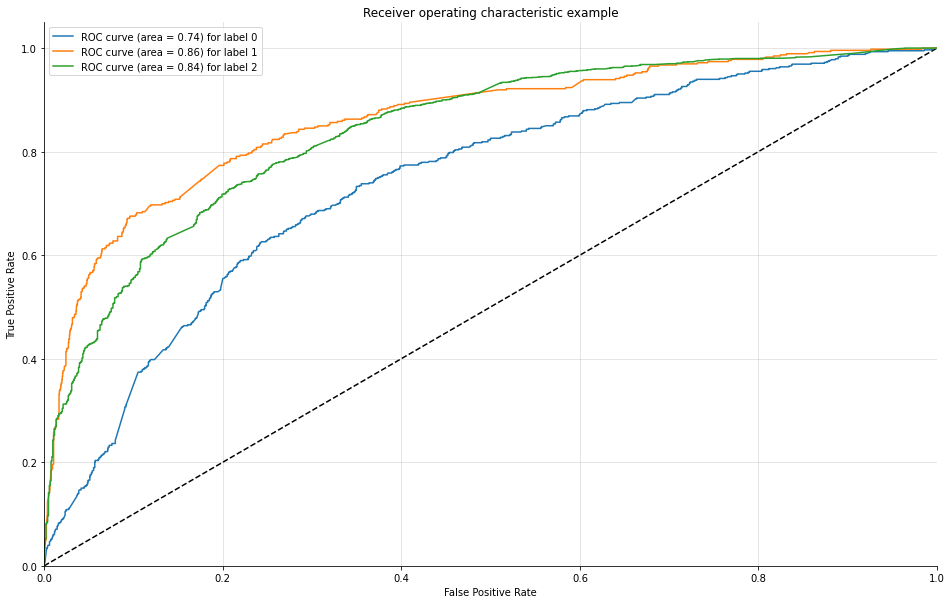

In [25]:
plot_multiclass_roc(log_reg, x_test, y_test, n_classes=3, figsize=(16, 10))

### Precision- Recall Curve

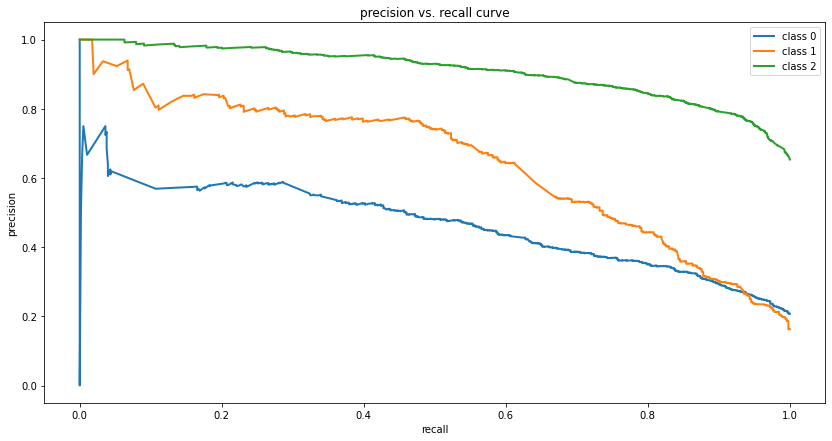

In [26]:
# Use label_binarize to be multi-label like settings
Y_train = label_binarize(y_train, classes=[0, 1, 2])
n_classes = Y_train.shape[1]

# We use OneVsRestClassifier for multi-label prediction
from sklearn.multiclass import OneVsRestClassifier

# Run classifier
classifier = OneVsRestClassifier(log_reg)
classifier.fit(x_train, Y_train)
y_score = classifier.decision_function(x_test)

Y_test = label_binarize(y_test, classes=[0, 1, 2])

# precision recall curve
precision = dict()
recall = dict()
fscore = dict()
thresh = dict()
average_precision = dict()
plt.figure(figsize=(14,7))
for i in range(n_classes):
    precision[i], recall[i], thresh[i] = precision_recall_curve(Y_test[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

### average precision

In [27]:
# average precision score
# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(Y_test, y_score,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'.format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.74


Can you choose an optimal threshold to maximum the F1-score?

**This is a multiclass classification problem, so we get N probabilities of the input belonging to each of the N classes, all adding up to 1. In this kind of scenario, the decision rule usually is simply picking the highest probability class.**

## Part 3. Please also explore using Naive Bayesian on this problem and report the result. 

(a) Please plot the ROC curve and compute the area under the ROC curve. 

(b) Please plot the precision recall curve and compute the average precision. Can you choose an optimal threshold to maximum the F1-score?

In [28]:
gauss=GaussianNB()
model=gauss.fit(x_train.toarray(),y_train.to_numpy())
y_pred= model.predict(x_test.toarray())

### ROC curve

In [29]:
def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    y_score = clf.predict_proba(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        print('AUC for label %i  = %0.2f' % (i,roc_auc[i]))
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

AUC for label 0  = 0.72
AUC for label 1  = 0.82
AUC for label 2  = 0.82


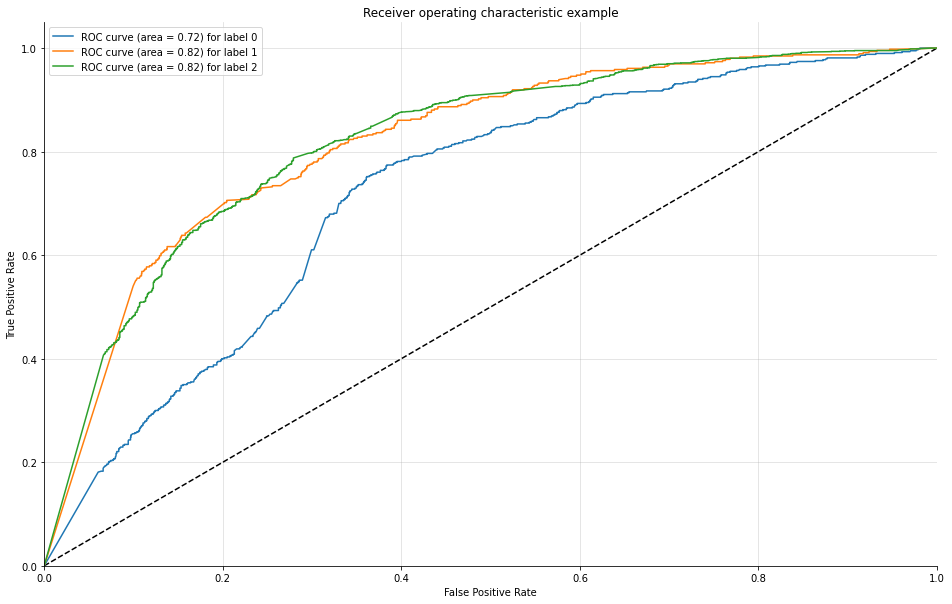

In [30]:
plot_multiclass_roc(model, x_test.toarray(), y_test.to_numpy(), n_classes=3, figsize=(16, 10))

### precision recall curve

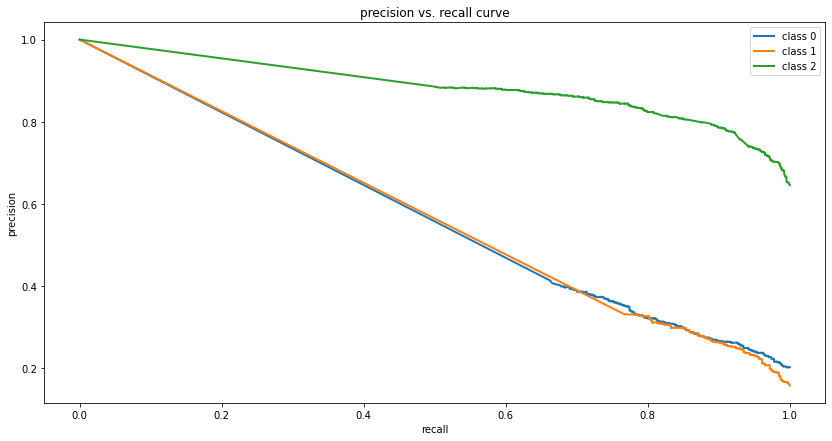

In [31]:
# Use label_binarize to be multi-label like settings
Y_train = label_binarize(y_train, classes=[0, 1, 2])
n_classes = Y_train.shape[1]

# We use OneVsRestClassifier for multi-label prediction
from sklearn.multiclass import OneVsRestClassifier

# Run classifier
classifier = OneVsRestClassifier(gauss)
classifier.fit(x_train.toarray(), Y_train)
y_score = classifier.predict_proba(x_test.toarray())

Y_test = label_binarize(y_test, classes=[0, 1, 2])

# precision recall curve
precision = dict()
recall = dict()
average_precision = dict()
plt.figure(figsize=(14,7))
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
    
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

### average precision 

In [32]:
# average precision score
# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(Y_test, y_score,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'.format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.52


Can you choose an optimal threshold to maximum the F1-score?

**This is a multiclass classification problem, so we get N probabilities of the input belonging to each of the N classes, all adding up to 1. In this kind of scenario, the decision rule usually is simply picking the highest probability class.**